In [151]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import random
import math
import sys
import numpy as np
%matplotlib inline

In [152]:
# Parametros 
TAMANHO_DO_PLANO = 100
QUANT_OBSTACULOS = 10
RAIO = 10

PONTO_INICIO = (0,0)
PONTO_FIM = (TAMANHO_DO_PLANO,TAMANHO_DO_PLANO)

mapa_obstaculos = []
arestas_globais = []



In [153]:
def encerrar_com_mensagem(ax,mensagem, cor='red'):
    ax.text(0.5, 0.5, mensagem, ha='center', va='center', fontsize=16, color=cor, transform=ax.transAxes)
    plt.draw()
    plt.show(block=True)
    sys.exit()



In [154]:
def calcular_distancia(ponto1, ponto2): 
    return math.sqrt((ponto1[0] - ponto2[0])**2 + (ponto1[1] - ponto2[1])**2) #  é a formula Euclidiana basicamente,  melhor forma pelo que eu vi ( a outra que eu tenti ainda tinha sobreposição na diagonal )



In [155]:
def verifica_intervalo(ponto_inserido,ponto_verifica):
    distancia = calcular_distancia(ponto_inserido,ponto_verifica)
    return ((distancia > (RAIO * 2)) | (distancia < 0))



In [156]:
def calcular_laterais(ponto_centro):
    ponto_cima = (ponto_centro[0] + RAIO,ponto_centro[1])
    ponto_baixo = (ponto_centro[0] - RAIO,ponto_centro[1])
    ponto_direito = (ponto_centro[0] ,ponto_centro[1] + RAIO)
    ponto_esquerdo = (ponto_centro[0] ,ponto_centro[1] - RAIO)
    return  ponto_cima,ponto_baixo,ponto_direito,ponto_esquerdo



In [157]:
def calcular_distancia_reta(r_a, r_b, r_c, c_x, c_y):
    cima = abs((r_a * c_x) + (r_b * c_y) + r_c)
    baixo = math.sqrt((r_a ** 2) + (r_b ** 2))
    return cima / baixo




In [158]:
def gerar_obstaculo_existente(novo_centro):
    if calcular_distancia(novo_centro, PONTO_INICIO) < RAIO:
        return True
    if calcular_distancia(novo_centro, PONTO_FIM) < RAIO:
        return True
    if any(not verifica_intervalo(novo_centro, obstaculo[0]) for obstaculo in mapa_obstaculos):
        return True
    return False



In [159]:
def posicionar_obstaculos():
    for _ in range(QUANT_OBSTACULOS):
        tentativas = 0
        while True:
            tentativas += 1
            if tentativas >= 1000:
                print(f"Não há mais espaço! Foram posicionados {len(mapa_obstaculos)} obstáculos.")
                return  # Sai do posicionamento, mas mantém os já posicionados
            x = random.uniform(RAIO, TAMANHO_DO_PLANO - RAIO)
            y = random.uniform(RAIO, TAMANHO_DO_PLANO - RAIO)
            novo_centro = (x, y)
            if gerar_obstaculo_existente(novo_centro):
                continue
            mapa_obstaculos.append((novo_centro, calcular_laterais(novo_centro)))
            break



In [160]:
def reta_livre_de_obstaculos(A, B, mapa_obstaculos, raio):
    for obstaculo in mapa_obstaculos:
        centro = obstaculo[0]
        laterais = obstaculo[1]
        
        # 1. Se A e B são laterais do mesmo círculo, bloqueia
        if A in laterais and B in laterais:
            return False
            
        # 2. Coeficientes da reta AB: ax + by + c = 0
        r_a = B[1] - A[1]
        r_b = A[0] - B[0] 
        r_c = B[1] * (B[0] - A[0]) - (B[1] - A[1]) * B[0]

        # 3. Distância do centro do círculo à reta
        dist_reta = calcular_distancia_reta(r_a, r_b, r_c, centro[0], centro[1])
        
        # 4. Se a distância for menor que o raio, há interseção
        if dist_reta < raio:
            # 5. Verifica se a interseção está no segmento AB (não na reta infinita)
            # Calcula o ponto mais próximo do centro na reta AB
            denominador = r_a * r_a + r_b * r_b
            if denominador != 0:
                px = (r_b * (r_b * centro[0] - r_a * centro[1]) - r_a * r_c) / denominador
                py = (r_a * (-r_b * centro[0] + r_a * centro[1]) - r_b * r_c) / denominador
                
                # Verifica se o ponto projetado está dentro do segmento AB
                min_x, max_x = min(A[0], B[0]), max(A[0], B[0])
                min_y, max_y = min(A[1], B[1]), max(A[1], B[1])
                
                if min_x <= px <= max_x and min_y <= py <= max_y:
                    return False
    return True



In [161]:
def gerar_arestas():
    # Gera todas as arestas válidas e as adiciona aos obstáculos
    # Formato: [ponto_centro, [pontos_laterais], [arestas]]
    
    # Primeiro, inicializa a lista de arestas para cada obstáculo
    for i, obstaculo in enumerate(mapa_obstaculos):
        if len(obstaculo) == 2:  # Se ainda não tem arestas
            mapa_obstaculos[i] = (obstaculo[0], obstaculo[1], [])
    
    # Arestas do início aos pontos laterais
    for obstaculo in mapa_obstaculos:
        for ponto_lateral in obstaculo[1]:
            if reta_livre_de_obstaculos(PONTO_INICIO, ponto_lateral, mapa_obstaculos, RAIO):
                aresta = (PONTO_INICIO, ponto_lateral, 'blue', '--')
                arestas_globais.append(aresta)
    
    # Arestas do fim aos pontos laterais
    for obstaculo in mapa_obstaculos:
        for ponto_lateral in obstaculo[1]:
            if reta_livre_de_obstaculos(PONTO_FIM, ponto_lateral, mapa_obstaculos, RAIO):
                aresta = (PONTO_FIM, ponto_lateral, 'red', '--')
                arestas_globais.append(aresta)
    
    # Arestas entre pontos laterais (evita duplicação)
    for i, obstaculo_a in enumerate(mapa_obstaculos):
        for j, obstaculo_b in enumerate(mapa_obstaculos):
            if i >= j:  # Evita duplicação (só processa i < j)
                continue
            for ponto_lateral_a in obstaculo_a[1]:
                for ponto_lateral_b in obstaculo_b[1]:
                    if reta_livre_de_obstaculos(ponto_lateral_a, ponto_lateral_b, mapa_obstaculos, RAIO):
                        aresta = (ponto_lateral_a, ponto_lateral_b, 'green', '-')
                        # Adiciona à lista do primeiro obstáculo
                        mapa_obstaculos[i] = (mapa_obstaculos[i][0], mapa_obstaculos[i][1], mapa_obstaculos[i][2] + [aresta])
    
    # Verifica caminho direto início-fim
    if reta_livre_de_obstaculos(PONTO_INICIO, PONTO_FIM, mapa_obstaculos, RAIO):
        aresta = (PONTO_INICIO, PONTO_FIM, 'purple', '-')
        arestas_globais.append(aresta)



In [162]:
def caminho_ini_fim():
    """
        Percorre o mapa de obstaculos entre os pontos dos obstaculos, mas caso não tenha obstaculos, faz a linha direta, utilizando o conceito de busca por profundidade    
    """
    
    if len(mapa_obstaculos) == 0:
        return [PONTO_INICIO, PONTO_FIM]
    
    # Implementação de busca por profundidade (DFS) para encontrar um caminho
    stack = [(PONTO_INICIO, [PONTO_INICIO])]
    visited = set()
    
    while stack:
        current, path = stack.pop()
        
        if current == PONTO_FIM:
            return path
        
        if current in visited:
            continue
        visited.add(current)
        
        # Adiciona vizinhos (pontos laterais dos obstáculos conectados)
        for obstaculo in mapa_obstaculos:
            for ponto_lateral in obstaculo[1]:
                if reta_livre_de_obstaculos(current, ponto_lateral, mapa_obstaculos, RAIO):
                    stack.append((ponto_lateral, path + [ponto_lateral]))
    
    return None  # Se não encontrar caminho




In [163]:
def inicializar_plot():
    fig, ax = plt.subplots()
    ax.set_xlim(0, TAMANHO_DO_PLANO)
    ax.set_ylim(0, TAMANHO_DO_PLANO)
    ax.set_aspect('equal')
    ax.grid(color='gray', linestyle='--', alpha=0.3)
    ax.axhline(0, color='white', linewidth=0.5)
    ax.axvline(0, color='white', linewidth=0.5)
    ax.plot(PONTO_INICIO[0], PONTO_INICIO[1], 'go', markersize=10, label='Início')
    ax.plot(PONTO_FIM[0], PONTO_FIM[1], 'ro', markersize=10, label='Fim')
    
    # Opção 2: Colocar fora da figura (à direita)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), frameon=True)
    plt.tight_layout()  # Ajusta automaticamente para não cortar
    
    return fig, ax


In [164]:
def plotar_arestas(ax):
    # Plota arestas globais (início/fim)
    for aresta in arestas_globais:
        ponto_a, ponto_b, cor, estilo = aresta
        ax.plot([ponto_a[0], ponto_b[0]], [ponto_a[1], ponto_b[1]], 
                color=cor, linestyle=estilo)
    
    # Plota arestas dos obstáculos
    for obstaculo in mapa_obstaculos:
        if len(obstaculo) > 2:  # Se tem arestas
            for aresta in obstaculo[2]:
                ponto_a, ponto_b, cor, estilo = aresta
                ax.plot([ponto_a[0], ponto_b[0]], [ponto_a[1], ponto_b[1]], 
                        color=cor, linestyle=estilo)

In [165]:
def plotar_obstaculos():
    # Inicializa o plot com início e fim
    _,ax = inicializar_plot()
    
    # Desenha todos os obstáculos
    for obstaculo in mapa_obstaculos:
        circulo = plt.Circle(obstaculo[0], RAIO, color="gray", alpha=0.7)
        for ponto in obstaculo[1]:
            ax.plot(ponto[0], ponto[1], 'o', markersize=2, color="black")
        ax.add_patch(circulo)
    
    plotar_arestas(ax)
    
    plt.title('Mapa de Obstáculos')
    plt.show()



Posicionados 10 obstáculos


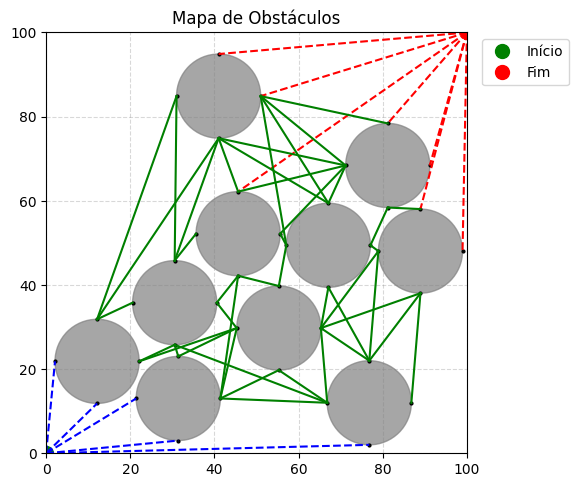

In [166]:
def main():
    posicionar_obstaculos()
    gerar_arestas()
    print(f"Posicionados {len(mapa_obstaculos)} obstáculos")
    plotar_obstaculos()

if __name__ == "__main__":
    main()

In [167]:
mapa_obstaculos[0]

((12.11746719841245, 21.84524498916689),
 ((22.11746719841245, 21.84524498916689),
  (2.1174671984124505, 21.84524498916689),
  (12.11746719841245, 31.84524498916689),
  (12.11746719841245, 11.84524498916689)),
 [((12.11746719841245, 31.84524498916689),
   (31.003310124219105, 84.88150803240632),
   'green',
   '-'),
  ((12.11746719841245, 31.84524498916689),
   (41.003310124219105, 74.88150803240632),
   'green',
   '-'),
  ((22.11746719841245, 21.84524498916689),
   (45.30794019800463, 29.75531458353042),
   'green',
   '-'),
  ((22.11746719841245, 21.84524498916689),
   (30.557017422446584, 25.786819119305626),
   'green',
   '-'),
  ((12.11746719841245, 31.84524498916689),
   (20.557017422446584, 35.786819119305626),
   'green',
   '-')])

In [168]:
mapa_obstaculos[0]

((12.11746719841245, 21.84524498916689),
 ((22.11746719841245, 21.84524498916689),
  (2.1174671984124505, 21.84524498916689),
  (12.11746719841245, 31.84524498916689),
  (12.11746719841245, 11.84524498916689)),
 [((12.11746719841245, 31.84524498916689),
   (31.003310124219105, 84.88150803240632),
   'green',
   '-'),
  ((12.11746719841245, 31.84524498916689),
   (41.003310124219105, 74.88150803240632),
   'green',
   '-'),
  ((22.11746719841245, 21.84524498916689),
   (45.30794019800463, 29.75531458353042),
   'green',
   '-'),
  ((22.11746719841245, 21.84524498916689),
   (30.557017422446584, 25.786819119305626),
   'green',
   '-'),
  ((12.11746719841245, 31.84524498916689),
   (20.557017422446584, 35.786819119305626),
   'green',
   '-')])

In [169]:
arestas_globais

[((0, 0), (2.1174671984124505, 21.84524498916689), 'blue', '--'),
 ((0, 0), (12.11746719841245, 11.84524498916689), 'blue', '--'),
 ((0, 0), (76.8086371831056, 2.0045864479775677), 'blue', '--'),
 ((0, 0), (21.411391573679328, 13.025103151854811), 'blue', '--'),
 ((0, 0), (31.411391573679328, 3.025103151854811), 'blue', '--'),
 ((100, 100), (51.003310124219105, 84.88150803240632), 'red', '--'),
 ((100, 100), (41.003310124219105, 94.88150803240632), 'red', '--'),
 ((100, 100), (91.19154888284685, 68.39745384635775), 'red', '--'),
 ((100, 100), (81.19154888284685, 78.39745384635775), 'red', '--'),
 ((100, 100), (45.63695757060096, 62.183677536667936), 'red', '--'),
 ((100, 100), (98.96874118230139, 48.041375319829385), 'red', '--'),
 ((100, 100), (88.96874118230139, 58.041375319829385), 'red', '--')]

In [170]:
dict_caminhos = {}

# Inicializa todos os pontos laterais no dicionário
for obstaculo in mapa_obstaculos:
    for ponto_lateral in obstaculo[1]:
        dict_caminhos[ponto_lateral] = []

# Adiciona PONTO_INICIO e PONTO_FIM ao dicionário
dict_caminhos[PONTO_INICIO] = []
dict_caminhos[PONTO_FIM] = []

# Processa arestas dos obstáculos (conexões entre pontos laterais de obstáculos diferentes)
for obstaculo in mapa_obstaculos:
    if len(obstaculo) > 2:  # Se tem arestas
        for aresta in obstaculo[2]:
            ponto_a, ponto_b = aresta[0], aresta[1]
            # Adiciona conexão bidirecional
            if ponto_a in dict_caminhos:
                dict_caminhos[ponto_a].append(ponto_b)

# Processa arestas globais (conexões com PONTO_INICIO e PONTO_FIM)
for aresta in arestas_globais:
    ponto_a, ponto_b = aresta[0], aresta[1]
    # Adiciona conexão bidirecional
    if ponto_a in dict_caminhos and ponto_b in dict_caminhos and ponto_a == PONTO_INICIO:
        dict_caminhos[ponto_a].append(ponto_b)
    elif ponto_a in dict_caminhos and ponto_b in dict_caminhos and ponto_a == PONTO_FIM:
        dict_caminhos[ponto_b].append(ponto_a)

In [171]:
# for (cima, baixo, esq, dir) in posicoes_centroides:
#     retas.append((cima, esq))
#     retas.append((cima, dir))
#     retas.append((baixo, esq))
#     retas.append((baixo, dir))

for obstaculo in mapa_obstaculos:
    ponto_cima,ponto_baixo,ponto_direito,ponto_esquerdo = obstaculo[1]
    dict_caminhos[ponto_cima].append(ponto_esquerdo)
    dict_caminhos[ponto_cima].append(ponto_direito)
    dict_caminhos[ponto_baixo].append(ponto_esquerdo)
    dict_caminhos[ponto_baixo].append(ponto_direito)

In [172]:
for key, value in dict_caminhos.items():
    print(f"Reta: {key}, Pontos: {value}")

Reta: (22.11746719841245, 21.84524498916689), Pontos: [(45.30794019800463, 29.75531458353042), (30.557017422446584, 25.786819119305626), (12.11746719841245, 11.84524498916689), (12.11746719841245, 31.84524498916689)]
Reta: (2.1174671984124505, 21.84524498916689), Pontos: [(12.11746719841245, 11.84524498916689), (12.11746719841245, 31.84524498916689)]
Reta: (12.11746719841245, 31.84524498916689), Pontos: [(31.003310124219105, 84.88150803240632), (41.003310124219105, 74.88150803240632), (20.557017422446584, 35.786819119305626)]
Reta: (12.11746719841245, 11.84524498916689), Pontos: []
Reta: (77.08418202671174, 49.43510572290921), Pontos: [(81.19154888284685, 58.39745384635775), (78.96874118230139, 48.041375319829385), (67.08418202671174, 39.43510572290921), (67.08418202671174, 59.43510572290921)]
Reta: (57.084182026711744, 49.43510572290921), Pontos: [(51.003310124219105, 84.88150803240632), (55.63695757060096, 52.183677536667936), (55.30794019800463, 39.75531458353042), (67.0841820267117

In [173]:
ponto_inicial = PONTO_INICIO
ponto_final = PONTO_FIM
possibilidade_atual = dict_caminhos[ponto_inicial]
print(possibilidade_atual)

def encontrar_possibilidades(ponto_atual, ponto_final, pilha=[], visitados=set()):
    if ponto_atual in visitados:
        return False 

    pilha.append(ponto_atual)
    visitados.add(ponto_atual)

    if ponto_atual == ponto_final:
        return True

    for prox_ponto in dict_caminhos.get(ponto_atual, []):
        if encontrar_possibilidades(prox_ponto, ponto_final, pilha, visitados):
            return True

    pilha.pop()
    return False

pilha = []
caminho_encontrado = encontrar_possibilidades(ponto_inicial, ponto_final, pilha)

[(2.1174671984124505, 21.84524498916689), (12.11746719841245, 11.84524498916689), (76.8086371831056, 2.0045864479775677), (21.411391573679328, 13.025103151854811), (31.411391573679328, 3.025103151854811)]


In [174]:
def ponto_mesmo_centroide(ponto1, ponto2):
    for obstaculo in mapa_obstaculos:
        centro, laterais = obstaculo[0], obstaculo[1]
        if ponto1 in laterais and ponto2 in laterais:
            return True, centro
    return False, None


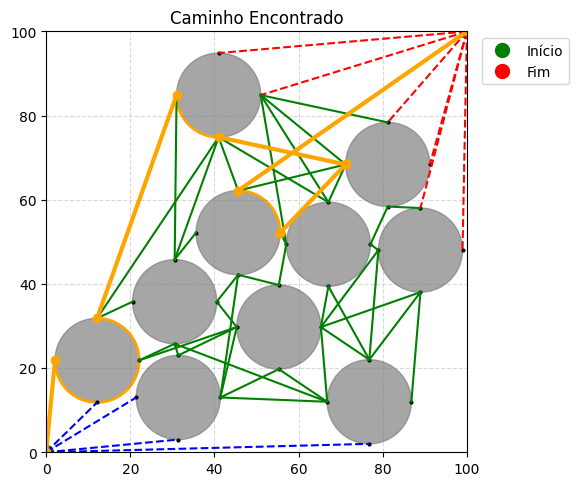

In [175]:
fig, ax = inicializar_plot()

# Plota obstáculos e arestas
for obstaculo in mapa_obstaculos:
    circulo = plt.Circle(obstaculo[0], RAIO, color="gray", alpha=0.7)
    for ponto in obstaculo[1]:
        ax.plot(ponto[0], ponto[1], 'o', markersize=2, color="black")
    ax.add_patch(circulo)
plotar_arestas(ax)

# Plota o caminho encontrado
if caminho_encontrado:
    for i in range(len(pilha) - 1):
        ponto1 = pilha[i]
        ponto2 = pilha[i + 1]
        
        mesmo_centro, centroid = ponto_mesmo_centroide(ponto1, ponto2)
        # print(mesmo_centro, centroid)
        if mesmo_centro:
            # Desenha arco entre pontos do mesmo obstáculo
            angulo1 = np.degrees(np.arctan2(ponto1[1] - centroid[1], ponto1[0] - centroid[0]))
            angulo2 = np.degrees(np.arctan2(ponto2[1] - centroid[1], ponto2[0] - centroid[0]))
            arco = Arc(centroid, width=2*RAIO, height=2*RAIO, theta1=angulo1, theta2=angulo2, color="orange", linewidth=2)
            ax.add_patch(arco)
        else:
            # Desenha linha reta entre pontos
            ax.plot([ponto1[0], ponto2[0]], [ponto1[1], ponto2[1]], 
                   color='orange', linewidth=3, marker='o')
    
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0), frameon=True)

plt.title('Caminho Encontrado')
plt.show()
